## Findings & Concluding Statement

### Confusion Matrix Summary

In [119]:
conf_matrix = {'Result': ['True Positive', 'True Negative', 'False Positive', 'False Negative'], 
               'Random Forest': [ 2124, 630, 43, 17], 
               'XGBoost': [ 2121, 636, 37, 20]
              }

matrix = pd.DataFrame(data = conf_matrix)
matrix = matrix.set_index('Result')
matrix

,Random Forest,XGBoost
Result,,
True Positive,2124,2121
True Negative,630,636
False Positive,43,37
False Negative,17,20


### Classification Metric Summary

In [112]:
metrics = {'Score': ['Precision (1)', 'Recall (1)', 'F1-score (1)', 'Precision (0)', 'Recall (0)', 'F1-score (0)'], 
               'Random Forest (%)': [ 98, 99, 99, 97, 94, 95], 
               'XGBoost (%)': [ 98, 99, 99, 97, 95, 96]
              }

scores = pd.DataFrame(data = metrics)
scores = scores.set_index('Score')
scores

,Random Forest (%),XGBoost (%)
Score,,
Precision (1),98,98
Recall (1),99,99
F1-score (1),99,99
Precision (0),97,97
Recall (0),94,95
F1-score (0),95,96


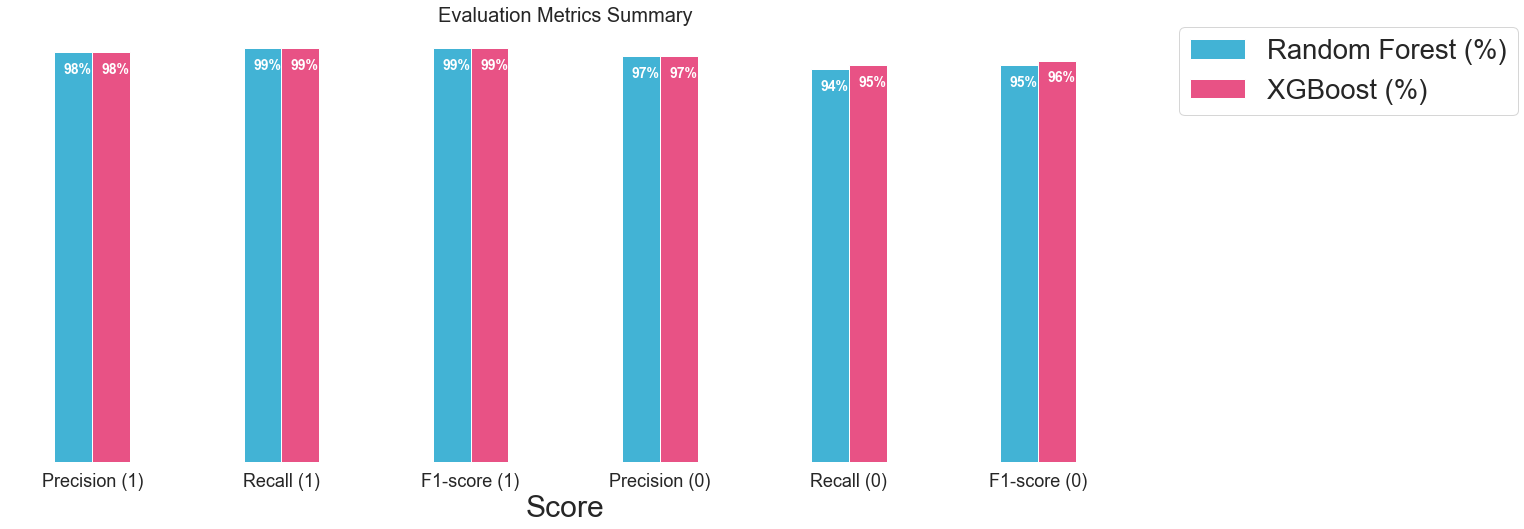

In [114]:
sns.set_style(style='white')
ax = scores.plot(kind='bar', figsize=(20,8), width=0.4, color=['#42b3d5', '#e85285'], fontsize=18)

plt.xticks(rotation=0, ha="center")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.spines['left'].set_linewidth(False)

ax.yaxis.grid()
ax.get_yaxis().set_visible(False)
plt.title('Evaluation Metrics Summary', fontsize=20)

for n in range(2):
    for index, val in enumerate(scores.iloc[:,n].transpose()): 
        label=str(val) + '%'
        
        if n==0:
            ax.annotate(label, xy=(index-0.15, val-5), color='#ffffff', fontsize=14, fontweight='bold')
        elif n==1:
            ax.annotate(label, xy=(index+0.05, val-5), color='#ffffff', fontsize=14, fontweight='bold')

plt.show()

### Findings

* **Classification metric:** Both the Random Forest and XGBoost classifier models have the same scores for accuracy and precision and recall for the majority class. However XGBoost performs marginally better in predicting the minority class for recall (95% v 94%) and F1-score (96% v 95%).
<br>
* **Confusion matrix:** As the objective is to predict the likelihood of an active employee leaving, we want the model that accurately predicts the minority (negative) class - has a lower false positive rate and a higher true negative. From the confusion matrix summary, it is observed that XGBoost has lower false positive (37) and higher true negative (636) predictions than Random Forest, which is desirable.
<br>
* **Feature Importance:** The top 5 features ranked by importance for both models are strong indicators for people leaving: 
    * **n_projects** (workload)
    * **satisfaction** (happiness)
    * **tenure** (experience)
    * **last_evaluation** (performance)
    * **ave_monthly_hrs** (workload) - *from the correlation matrix in the data pre-processing section, there was a strong correlation between **ave_monthly_hrs** and **n_projects**.*



### Concluding Statement

**The objective was to build a binary classification model that predicts employee churn in a mid-sized company.**


* **Winning model:**  XGBoost classifier with an accuracy of 99%, vs a baseline of 76%.
* **Hyperparameter:** Tuned using GridsearchCV with a stratified 10-fold cross validation

> `XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=175,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, ...)`

* **Feature importances:** The feature importances can be used as predictors for the risk categories identified in section 4.4.1.3. A strategic retention plan should be drawn for each risk category group.

    
> - Overworked
> - Unmotivated
> - Workaholics
> - Demotivated
> - Underperformers
> - Overachievers
> - Stars
> - Bad hires


### Model Deployment & Loading 
 

As the company generates more employee data the algorithm can be deployed using the new dataset. With more employee records, the model can generate more accurate predictions to identify employees at with a high likelihood to leave the company.

#### Model deployment

In [162]:
# Write a data pre-processing function that allows the HR team to transform new data for modelling

def data_prep(df):
    '''
    Data processing Step - cleaning. Function drops employees out of business scope and duplicate entries, deals with missing values and data integrity issues, and performs one-hot encoding of categorical variables
    
    Arguments
    df - original dataframe
    
    Output 
    df - cleaned dataframe
    '''
        
    # drop duplicate data
    df.drop_duplicates(inplace=True)
    
    # missing data in numerical features
    df.filed_complaint.fillna(0, inplace=True)
    df.recently_promoted.fillna(0, inplace=True)
       
    # clean up departments
    df.department.replace('information_technology', 'IT', inplace=True) 
    
    # remove out-of-scope temporary employees
    df = df[df.department != 'temp']

    # missing data in categorical features
    df['department'].fillna('unknown', inplace=True)
    df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)
    df.last_evaluation.fillna(0, inplace=True)

    # one-hot encoding of categorical variables
    df['status'] = pd.get_dummies(df.status).Left
    cleaned_df = pd.get_dummies(df, columns=['department', 'salary'])
    
    return cleaned_df

In [127]:
# Testing data cleaning Function

# load the original dataset
df = pd.read_csv("employee_data.csv")
cleaned_data_deployed = data_prep(df)
cleaned_data_deployed.reset_index(drop=True, inplace=True);

In [128]:
# Dataset from using cleaning_function
print(cleaned_data_deployed.shape)
display(cleaned_data_deployed.head(10))

(14068, 23)


,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,department_IT,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,department_unknown,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [152]:
# prepare the data for train_test split
y = cleaned_data_deployed.status
X = cleaned_data_deployed.drop('status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [133]:
# Set up final model
final_model = grid_objx.best_estimator_

In [153]:
# Fit the final model
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=175,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, ...)

In [154]:
# save the XGBoost classifier model to a pickle file

joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [146]:
# save the column feature names as a list to a pickle file

joblib.dump(list(X.columns), 'col_names.pkl')

['col_names.pkl']

#### Loading the Model

In [147]:
column_names = joblib.load('col_names.pkl')

In [149]:
column_names

['avg_monthly_hrs',
 'filed_complaint',
 'last_evaluation',
 'n_projects',
 'recently_promoted',
 'satisfaction',
 'tenure',
 'last_evaluation_missing',
 'department_IT',
 'department_admin',
 'department_engineering',
 'department_finance',
 'department_management',
 'department_marketing',
 'department_procurement',
 'department_product',
 'department_sales',
 'department_support',
 'department_unknown',
 'salary_high',
 'salary_low',
 'salary_medium']

In [150]:
loaded_model = joblib.load('final_model.pkl')

In [158]:
np.set_printoptions(threshold=np.inf)
loaded_model.predict(X_test)

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,